In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pylab as plt 
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 4

In [5]:
class Processing:
    def __init__(self, filedataset, begining_training, end_training,end_testing, timestamp, features, target):
        self.timestamp = timestamp
        self.features  = features
        self.begining_training = begining_training
        self.end_training = end_training
        self.end_testing = end_testing
        self.df  = self.importDataset()
        self.x_train = []
        self.y_train = []
        self.x_test  = []
        self.y_test  = []
        self.scaler_x = None
        self.scaler_y = None
        self.target = target
        self.df_training =  None
        self.df_test = None
        self.splitData()
    
    def importDataset(self):
        parser = lambda x: pd.datetime.strptime(x, "%Y.%m.%d %H:%M:%S")
        df = pd.read_csv( filedataset, sep=';', header=0, parse_dates=['time'],date_parser=parser) 
        return df
    
    def selectInterval(self, start, end):
        mask = (self.df['time'] > start) & (self.df['time'] <= end )
        return self.df.loc[mask]
    
    def scalerDataset(self, dataset):
        self.scaler_x = MinMaxScaler()
        self.scaler_y = MinMaxScaler()
        self.scaler_x.fit(dataset)
        self.scaler_y.fit(self.df_training[[target]])
        return self.scaler_x.transform(dataset)

    def processXY(self, dataframe):
        length = len(dataframe)
        x_data = []
        y_data = []
        for i in range(self.timestamp, length):
            x_data.append( dataframe[i-self.timestamp:i,:])
            y_data.append( dataframe[i,self.features.index(target)])
        x_data = np.array(x_data)
        y_data = np.array(y_data)
        x_data = np.reshape(x_data, (x_data.shape[0], self.timestamp, len(features)))
        return x_data, y_data
     
    def splitData(self):
        #Selecionando Intervalos de datas para treino
        self.df_training = self.selectInterval(self.begining_training, self.end_training)
        #selecionando colunas para treino
        self.df_training = self.df_training[self.features]
        #Escalando o dataset de treino usando a funcao MinMax()
        self.x_train = self.scalerDataset(self.df_training)
        #Processando o dataset com o shape adequado para a modelagem 
        self.x_train, self.y_train = self.processXY( self.x_train )
        #Selecionando Intervalos de datas para teste
        self.df_test = self.selectInterval(self.end_training, self.end_testing)
        #selecionando colunas do dataset para teste
        self.x_test = self.df_test[self.features]
        #Escalando o dataset de treino
        self.x_test = self.scaler_x.transform(self.x_test)
        #Processando o dataset com o shape adequado para a modelagem 
        self.x_test , self.y_test  = self.processXY( self.x_test )


#########################Fim da classe de processamento############################################################

class Training:
    def __init__(self, ds, neurons, timestamp, features, epochs):
        self.model = None
        self.ds = ds
        self.neurons = neurons
        self.timestamp = timestamp
        self.features = features
        self.epochs = epochs
        self.trainingLSTM()
        
    def configuringLSTM(self):
        self.model = Sequential()
        self.model.add(LSTM(units = self.neurons, return_sequences = False, input_shape=( self.timestamp , len(self.features) ) ))
        self.model.add(Dropout(0.01))
        self.model.add(Dense(1))
        self.model.compile(loss='mae', optimizer='adam')
    
    def trainingLSTM(self):
        self.configuringLSTM()
        self.model.fit(self.ds.x_train, self.ds.y_train, epochs = self.epochs)
        self.model.save('LSTM_GBPUSD_with_scaler')

#########################Fim da classe de Treinamento#############################################################

class Testing:
    def __init__(self, modelTraining, ds ):
        self.modelTraining  = modelTraining
        self.ds     = ds
        self.y_pred = []
        self.predictedPrice = []
        self.prevision = None
        self.time = None
        self.max = None
        self.min = None
        self.result_to_csv = None
        self.predicting()
        self.estatistical()
    
    def predicting(self):
        self.predictedPrice =  self.modelTraining.model.predict(self.ds.x_test) 
        self.predictedPrice =  self.ds.scaler_y.inverse_transform(self.predictedPrice)
    
    def estatistical(self):
        self.prevision = pd.DataFrame(data=self.predictedPrice, columns=['Previsão'])
        self.time      = pd.DataFrame(data=self.ds.df_test['time'].shift(-self.ds.timestamp).dropna().values, columns=['Data'])
        self.maxima    = pd.DataFrame(data=self.ds.df_test['low1'].shift(-self.ds.timestamp).dropna().values, columns=['Máxima'])
        self.minima    = pd.DataFrame(data=self.ds.df_test['high1'].shift(-self.ds.timestamp).dropna().values, columns=['Minima'])
        frames_to_csv= [ self.time, self.maxima, self.minima, self.prevision ]
        self.result_to_csv = pd.concat( frames_to_csv, axis=1, join='inner')
        
    def saveToCsv(self):
        self.result_to_csv.to_csv('previsoes.csv', mode='a', header=False,index=False)
      
    def graphicMaxMin(self, window):
        y_test = []
        y_test = self.ds.df_test['close1'].shift(-self.ds.timestamp).dropna()
        # shift =  y_test.values[0] - self.prevision.iloc[0,0]
        # self.prevision = self.prevision+shift-0.0005
        plt.plot(y_test[:window], color='red', label='Preço Atual das Ações')
        plt.plot(y_test.index.values[:window], self.prevision.iloc[:window,0] , '.')
        plt.fill_between(y_test.index.values[:window], self.maxima.iloc[:window,0], self.minima.iloc[:window,0], alpha=0.5)
        plt.title('Previsão de Preço de Ações')
        plt.xlabel('Tempo')
        plt.ylabel('Preço das Ações')
        plt.legend()
        plt.show()
        
        

    



In [206]:
begining_training = '2017-01-01 00:00:00'

end_training = '2021-01-01 00:00:00'

end_test = '2022-01-01 00:00:00'

filedataset  = 'arquivos_de_coleta/EURUSD_15.csv'                                                                                                      
features = ['open','high','low','ticks','close']

target   = 'close'

timestamp = 2

neurons = 120

epochs  = 32

datasetProcessed = Processing( filedataset, begining_training, end_training, end_test, timestamp, features, target  )

# modelTrained = Training( datasetProcessed, neurons, timestamp, features, epochs )

# estatisticalTested  = Testing( modelTrained, datasetProcessed )


In [211]:
begin = '2018-01-01 01:00:00'       
end = '2018-12-20 22:00:00'
dataset = datasetProcessed.selectInterval(begin, end  )
features = ['time','open','high','low','ticks','close']
df = dataset[features]

In [212]:
df['volatile'] = df['low'] - df['high']
df['volatile'] = df['volatile']*100000
df['volatile'] = df['volatile'].astype(int)


In [ ]:
# plt.plot(df['volatile'],df['ticks'] , color='red', label='Preço Atual das Ações')
# # df[['volatile','ticks']].plot()
# scaler = MinMaxScaler()
# df[['volatile','ticks']] = scaler.fit_transform(df[['volatile','ticks']])
# # df[['volatile','ticks']].loc[:3].plot()
# plt.scatter(df['volatile'],df['ticks'] , color='red', label='Preço Atual das Ações')
# plt.show()

In [213]:
# plt.plot(df['volatile'].loc[:3], color='red', label='Preço Atual das Ações')
# print(df['volatile'].loc[:3].describe())
# print( df['ticks'].loc[:3].describe())
# scaler = MinMaxScaler(feature_range=(0,100))

# df[['volatile','ticks']] = scaler.fit_transform(df[['volatile','ticks']])

volatile = df['volatile'].rolling(window=12)
ticks = df['ticks'].rolling(window=12)
df['volatile_mean'] = volatile.mean()
df['ticks_mean'] = ticks.mean()
df = df.dropna()
df



time     open     high      low  ticks    close  \
11    2018-01-02 12:45:00  1.20777  1.20665  1.20810   1342  1.20683   
12    2018-01-02 13:00:00  1.20683  1.20630  1.20705    939  1.20642   
13    2018-01-02 13:15:00  1.20642  1.20619  1.20686   1024  1.20654   
14    2018-01-02 13:30:00  1.20653  1.20642  1.20685    581  1.20655   
15    2018-01-02 13:45:00  1.20656  1.20591  1.20673    710  1.20592   
...                   ...      ...      ...      ...    ...      ...   
24223 2018-12-20 21:00:00  1.14703  1.14700  1.14841   1671  1.14827   
24224 2018-12-20 21:15:00  1.14828  1.14798  1.14849   1519  1.14799   
24225 2018-12-20 21:30:00  1.14797  1.14696  1.14812   1934  1.14696   
24226 2018-12-20 21:45:00  1.14696  1.14653  1.14739   1528  1.14714   
24227 2018-12-20 22:00:00  1.14712  1.14651  1.14713   1273  1.14674   

       volatile  volatile_mean   ticks_mean  
11          144      85.083333  1227.250000  
12           75      85.916667  1183.333333  
13           67      83.416667  1161.500000  
14           42      82.833333  1090.583333  
15           81      85.750000  1064.500000  
...         ...            ...          ...  
24223       140     123.500000  1612.666667  
24224        51     119.166667  1558.583333  
24225       116     122.083333  1585.500000  
24226        86     113.583333  1532.916667  
24227        61     101.083333  1486.250000  

[24217 rows x 9 columns]

167


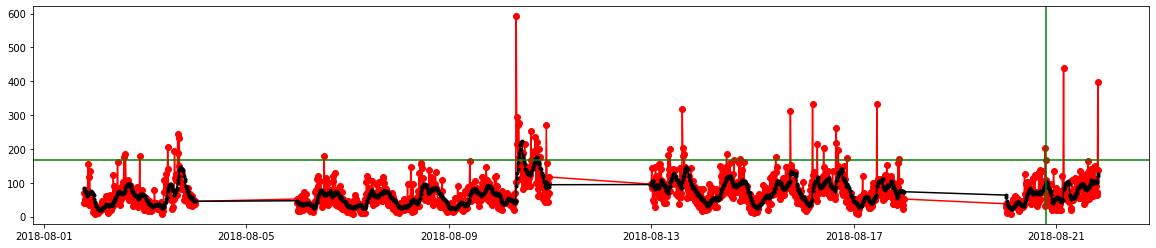

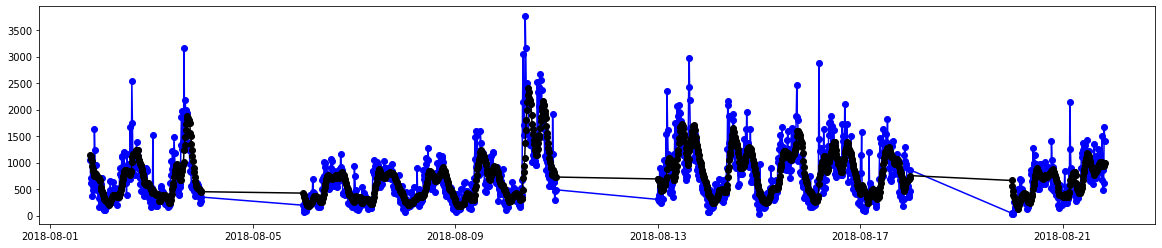

In [214]:
start_date = '2018-01-01 18:45:00'
end_date   = '2018-08-21 20:00:00'
mask = (df['time'] > start_date) & (df['time'] <= end_date)
rebaixamento1 = df.loc[mask]
print(rebaixamento1[(rebaixamento1['time'] > '2018-08-20 18:45:00') & (df['time'] <= '2018-08-20 20:00:00')].max()['volatile'])
plt.plot(rebaixamento1['time'], rebaixamento1['volatile'] ,marker='o', color='red', label='Preço Atual das Ações')
plt.plot(rebaixamento1['time'], rebaixamento1['volatile_mean'] ,marker='.', color='black', label='Preço Atual das Ações')
plt.axvline(pd.Timestamp('2018-08-20 19:00:00'), color='g')
plt.axhline(y=rebaixamento1[(rebaixamento1['time'] > '2018-08-20 18:45:00') & (df['time'] <= '2018-08-20 20:00:00')].max()['volatile'],color='g')
plt.show()
plt.plot(rebaixamento1['time'], rebaixamento1['ticks'] , marker='o', color='blue', label='Preço Atual das Ações')
plt.plot(rebaixamento1['time'], rebaixamento1['ticks_mean'] , marker='o', color='black', label='Preço Atual das Ações')
plt.show()
# plt.plot(df['time'], df['close'] , color='blue', label='Preço Atual das Ações')

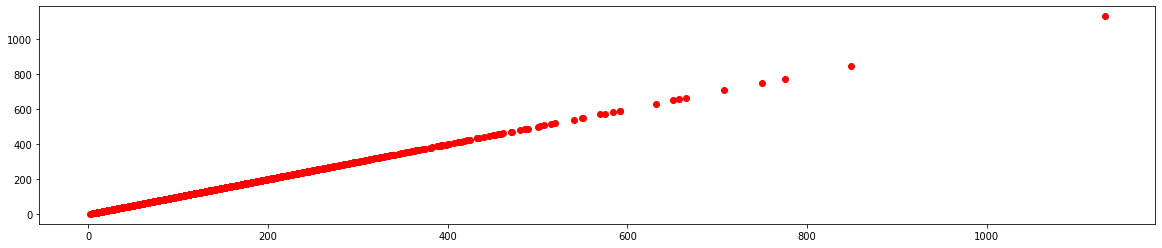

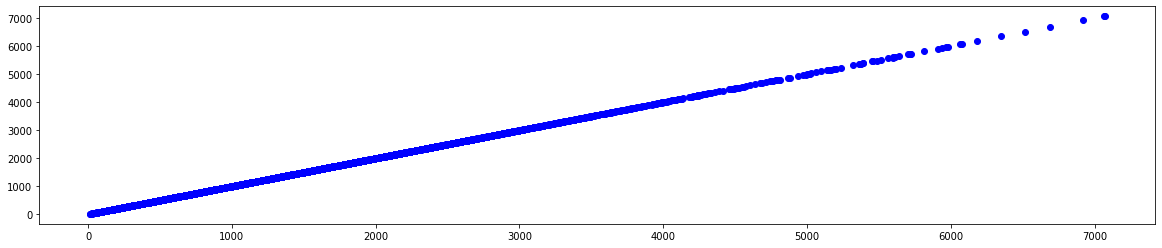

In [172]:
plt.scatter(df['volatile'], df['volatile'] , color='red', label='Preço Atual das Ações')
plt.show()
plt.scatter(df['ticks'], df['ticks'] , color='blue', label='Preço Atual das Ações')

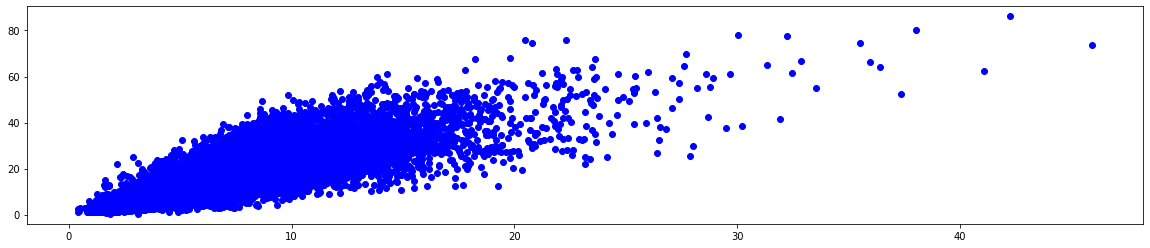

In [101]:
plt.scatter(df['volatile'], df['ticks'] , color='blue', label='Preço Atual das Ações')

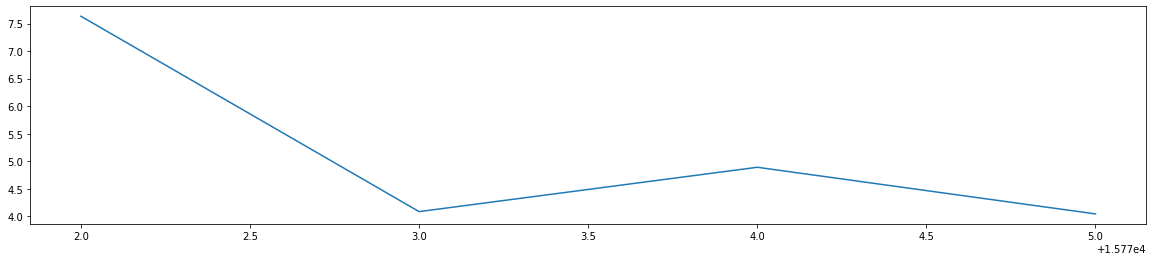

In [73]:

# fig, ax = plt.subplots()
# ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
# ax.plot(df['volatile_mean'],df['ticks'] , marker='.', linestyle='', ms=12, label='all')
# start_date = '2018-08-20 19:00:00'
# end_date   = '2018-08-20 20:00:00'
# mask = (df['time'] > start_date) & (df['time'] <= end_date)
# rebaixamento1 = df.loc[mask] 
# ax.plot(rebaixamento1['volatile'],rebaixamento1['ticks'] , marker='o', linestyle='', ms=12, label='rebaixamento1')
# ax.legend()
# plt.show()
# rebaixamento1['ticks'].plot()